# Import Model

In [1]:
from cameo import models
from cameo import load_model
from cameo import fba
from escher import Builder
import pandas as pd
import numpy as np
import cobra
from time import sleep

/home/matinnu/anaconda3/envs/lab_rotation_3/lib/python3.7/site-packages/sympy/__init__.py:676: SymPyDeprecationWarning: 

importing sympy.core.singleton with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.core.singleton instead.
See https://github.com/sympy/sympy/issues/18245 for more info.

  deprecated_since_version="1.6").warn()


# Simulate Model - WT E. coli

In [2]:
model = load_model('iML1515')
model.solver = 'gurobi'
model

Using license file /home/matinnu/gurobi.lic
Academic license - for non-commercial use only


Name,iML1515
Memory address,0x07fbf8ae8afd0
Number of metabolites,1877
Number of reactions,2712
Number of groups,0
Objective expression,0.0 + 1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"cytosol, extracellular space, periplasm"


In [3]:
%time fba_result = fba(model)
fba_result[model.reactions.BIOMASS_Ec_iML1515_core_75p37M]

CPU times: user 438 ms, sys: 15.6 ms, total: 453 ms
Wall time: 464 ms


0.8769972144269728

In [4]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.004565,0,0.00%
cl_e,EX_cl_e,0.004565,0,0.00%
cobalt2_e,EX_cobalt2_e,2.192E-05,0,0.00%
cu2_e,EX_cu2_e,0.0006218,0,0.00%
fe2_e,EX_fe2_e,0.01409,0,0.00%
glc__D_e,EX_glc__D_e,10,6,100.00%
k_e,EX_k_e,0.1712,0,0.00%
mg2_e,EX_mg2_e,0.007608,0,0.00%
mn2_e,EX_mn2_e,0.000606,0,0.00%
mobd_e,EX_mobd_e,6.139E-06,0,0.00%


In [5]:
model.metabolites.atp_c.summary()

Percent,Flux,Reaction,Definition
75.70%,70.43,ATPS4rpp,adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c
18.38%,17.11,PGK,3pg_c + atp_c <=> 13dpg_c + adp_c
5.92%,5.51,SUCOAS,atp_c + coa_c + succ_c <=> adp_c + pi_c + succoa_c
Percent,Flux,Reaction,Definition
0.00%,-0.0005867,4HTHRK,4hthr_c + atp_c --> adp_c + h_c + phthr_c
0.12%,-0.1119,AACPS3,ACP_c + atp_c + hdca_c --> amp_c + palmACP_c + ppi_c
0.14%,-0.1319,AACPS4,ACP_c + atp_c + hdcea_c --> amp_c + hdeACP_c + ppi_c
0.07%,-0.06825,AACPS7,ACP_c + atp_c + ddca_c --> amp_c + ddcaACP_c + ppi_c
0.07%,-0.06826,ACCOAC,accoa_c + atp_c + hco3_c --> adp_c + h_c + malcoa_c + pi_c
0.28%,-0.2594,ACGK,acglu_c + atp_c --> acg5p_c + adp_c


In [101]:
builder = Builder(
    map_name='e_coli_core.Core metabolism',
    reaction_data=fba_result.fluxes,
)
builder

Builder(reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': -0.022947509112696166, 'SHK3Dr': 0.3…

# Xylitol strain knockout model

In [7]:
# copy model to create mutant
mutant_xylitol = load_model('result/iML1515_xylitol_strain.xml')
mutant_xylitol.solver = 'gurobi'

In [8]:
%time fba_knockout_xylitol = fba(mutant_xylitol)
fba_knockout_xylitol[mutant_xylitol.reactions.BIOMASS_Ec_iML1515_core_75p37M]

CPU times: user 422 ms, sys: 31.2 ms, total: 453 ms
Wall time: 467 ms


0.7776142830847736

In [9]:
mutant_xylitol.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.004047,0,0.00%
cl_e,EX_cl_e,0.004047,0,0.00%
cobalt2_e,EX_cobalt2_e,1.944E-05,0,0.00%
cu2_e,EX_cu2_e,0.0005513,0,0.00%
fe2_e,EX_fe2_e,0.01249,0,0.00%
glc__D_e,EX_glc__D_e,10,6,100.00%
k_e,EX_k_e,0.1518,0,0.00%
mg2_e,EX_mg2_e,0.006746,0,0.00%
mn2_e,EX_mn2_e,0.0005373,0,0.00%
mobd_e,EX_mobd_e,5.443E-06,0,0.00%


In [10]:
mutant_xylitol.metabolites.atp_c.summary()

Percent,Flux,Reaction,Definition
69.39%,57.79,ATPS4rpp,adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c
21.48%,17.89,PGK,3pg_c + atp_c <=> 13dpg_c + adp_c
9.13%,7.605,SUCOAS,atp_c + coa_c + succ_c <=> adp_c + pi_c + succoa_c
Percent,Flux,Reaction,Definition
0.00%,-0.0005202,4HTHRK,4hthr_c + atp_c --> adp_c + h_c + phthr_c
0.12%,-0.09925,AACPS3,ACP_c + atp_c + hdca_c --> amp_c + palmACP_c + ppi_c
0.14%,-0.117,AACPS4,ACP_c + atp_c + hdcea_c --> amp_c + hdeACP_c + ppi_c
0.07%,-0.06052,AACPS7,ACP_c + atp_c + ddca_c --> amp_c + ddcaACP_c + ppi_c
0.07%,-0.06052,ACCOAC,accoa_c + atp_c + hco3_c --> adp_c + h_c + malcoa_c + pi_c
0.28%,-0.23,ACGK,acglu_c + atp_c --> acg5p_c + adp_c


In [11]:
builder = Builder(
    map_name='e_coli_core.Core metabolism',
    reaction_data=fba_knockout_xylitol.fluxes,
)
builder.highlight_missing = True
builder

Builder(highlight_missing=True, reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': -0.020347055…

# Isobutyric strain knockout model

In [102]:
# copy model to create mutant
mutant_isobutyric = load_model('result/iML1515_isobutyric_strain.xml')
mutant_isobutyric.solver = 'gurobi'

In [103]:
mutant_isobutyric.reactions.CYTBDpp.bounds = [0.0, 0.0]

In [104]:
mutant_isobutyric.medium

{'EX_pi_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_slnt_e': 1000.0}

In [106]:
medium = mutant_isobutyric.medium
medium["EX_ac_e"] = 10.0
mutant_isobutyric.medium = medium

medium["EX_glc__D_e"] = 10.0
mutant_isobutyric.medium = medium

medium["EX_xyl__D_e"] = 10.0
mutant_isobutyric.medium = medium

In [107]:
mutant_isobutyric.metabolites.xyl__D_e.reactions

frozenset({<Reaction EX_xyl__D_e at 0x7fbf6cc26550>,
           <Reaction XYLtex at 0x7fbf6a7dbf10>})

In [91]:
mutant_isobutyric.reactions.EX_xyl__D_e

Reaction identifier,EX_xyl__D_e
Name,D-Xylose exchange
Memory address,0x07fbf6ed073d0
Stoichiometry,xyl__D_e --> D-Xylose -->
GPR,
Lower bound,0
Upper bound,1000.0


In [108]:
%time fba_knockout_isobutyric = fba(mutant_isobutyric)
fba_knockout_isobutyric[mutant_isobutyric.reactions.BIOMASS_Ec_iML1515_core_75p37M]

CPU times: user 297 ms, sys: 93.8 ms, total: 391 ms
Wall time: 454 ms


1.1213914838170393

In [109]:
fba_knockout_isobutyric[mutant_isobutyric.reactions.get_by_id('EX_ac_e')]

-10.0

In [81]:
fba_knockout_isobutyric.summ

0.0

In [110]:
mutant_isobutyric.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,10,2,25.00%
ca2_e,EX_ca2_e,0.005837,0,0.00%
cl_e,EX_cl_e,0.005837,0,0.00%
cobalt2_e,EX_cobalt2_e,2.803E-05,0,0.00%
cu2_e,EX_cu2_e,0.0007951,0,0.00%
fe2_e,EX_fe2_e,0.01801,0,0.00%
glc__D_e,EX_glc__D_e,10,6,75.00%
k_e,EX_k_e,0.2189,0,0.00%
mg2_e,EX_mg2_e,0.009728,0,0.00%
mn2_e,EX_mn2_e,0.0007749,0,0.00%


In [111]:
builder = Builder(
    map_name='e_coli_core.Core metabolism',
    reaction_data=fba_knockout_isobutyric.fluxes,
)
builder
builder.highlight_missing = True
builder

Builder(highlight_missing=True, reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': 0.0302966337…

In [118]:
from cobra.util.solver import linear_reaction_coefficients
#print(linear_reaction_coefficients(model))

# change the objective to ATPM
mutant_isobutyric.objective = "ATPM"

# The upper bound should be 1000, so that we get
# the actual optimal value
mutant_isobutyric.reactions.get_by_id("ATPM").upper_bound = 1000.
linear_reaction_coefficients(mutant_isobutyric)

{<Reaction ATPM at 0x7fbf6a431e90>: 1.0}

In [119]:
mutant_isobutyric.optimize().objective_value

297.4999999999998

In [120]:
mutant_isobutyric.reactions.EX_isobuta_e.flux

0.0

# Compare

In [18]:
normal_flux = fba_result.fluxes.to_frame()
normal_flux = normal_flux.rename(columns={'fluxes':'normal'})

In [47]:
xylitol_flux = fba_knockout_xylitol.fluxes.to_frame()
xylitol_flux = xylitol_flux.rename(columns={'fluxes':'xylitol'})

In [ ]:
x

In [48]:
isobutyric_flux = fba_knockout_isobutyric.fluxes.to_frame()
isobutyric_flux = isobutyric_flux.rename(columns={'fluxes':'isobutyric'})

In [54]:
isobutyric_flux.loc[ 'EX_ac_e' , : ]

isobutyric    0.0
Name: EX_ac_e, dtype: float64

In [21]:
result = normal_flux.join(xylitol_flux)
result = result.join(isobutyric_flux)
result

,normal,xylitol,isobutyric
CYTDK2,0.000000,0.000000,0.000000
XPPT,0.000000,0.000000,0.000000
HXPRT,0.000000,0.000000,0.000000
NDPK5,-0.022948,-0.020347,0.037395
SHK3Dr,0.334240,0.296364,0.527520
...,...,...,...
MPTS,0.000000,0.000000,0.000000
MOCOS,0.000000,0.000000,0.000000
BMOGDS2,0.000000,0.000000,0.000000
FESD2s,0.000000,0.000000,0.000000


In [22]:
flux_no_zeroes = (result != 0).any(axis=1)
flux_no_zeroes = result.loc[flux_no_zeroes]
flux_no_zeroes['d_xylitol'] = flux_no_zeroes['xylitol'] - flux_no_zeroes['normal']
flux_no_zeroes['d_isobutyric'] = flux_no_zeroes['isobutyric'] - flux_no_zeroes['normal']
flux_no_zeroes

/home/matinnu/anaconda3/envs/lab_rotation_3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/matinnu/anaconda3/envs/lab_rotation_3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,normal,xylitol,isobutyric,d_xylitol,d_isobutyric
NDPK5,-0.022948,-0.020347,0.037395,0.002600,0.060343
SHK3Dr,0.334240,0.296364,0.527520,-0.037877,0.193279
NDPK8,0.000000,0.000000,0.036217,0.000000,0.036217
DHORTS,-0.290106,-0.257231,-0.457864,0.032875,-0.167758
OMPDC,0.290106,0.257231,0.457864,-0.032875,0.167758
...,...,...,...,...,...
TYRL,0.000196,0.000173,0.000309,-0.000022,0.000113
THZPSN3,0.000196,0.000173,0.000309,-0.000022,0.000113
PAI2T,0.000393,0.000348,0.000620,-0.000045,0.000227
4HTHRK,0.000587,0.000520,0.000926,-0.000066,0.000339


In [23]:
delta_flux = flux_no_zeroes.drop(columns=['normal','xylitol','isobutyric'])

<AxesSubplot:>

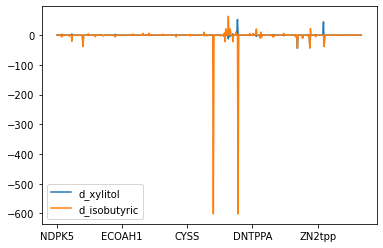

In [24]:
delta_flux.plot()

In [25]:
delta_flux.d_xylitol.nlargest(25)

CYTBDpp         52.839704
NADH16pp        44.570045
GLCtex_copy1    10.000000
O2tpp            4.291298
O2tex            4.291298
EX_co2_e         4.079213
AKGDH            2.043186
MDH              1.939550
FUM              1.939550
CS               1.936330
ICDHyr           1.936330
ACONTb           1.936330
ACONTa           1.936330
PGI              1.626776
PDH              1.621671
EX_h2o_e         1.454784
EX_nh4_e         1.073327
ENO              0.952028
Htex             0.913170
GLUDy            0.849856
GAPD             0.781305
ADK3             0.715788
DHAPT            0.673586
F6PA             0.673586
TPI              0.642735
Name: d_xylitol, dtype: float64

In [26]:
delta_flux.d_isobutyric.nlargest(25)

ATPS4rpp        63.593872
EX_o2_e         21.897849
THD2pp          21.253388
CO2tpp          20.815610
CO2tex          20.815610
HEX1            10.000000
GLCtex_copy1    10.000000
GLCt2pp         10.000000
H2Otex           7.423546
H2Otpp           7.423546
DHAPT            6.246435
F6PA             6.246435
SUCOAS           6.236288
NH4tpp           5.477027
NH4tex           5.477027
EX_h_e           4.659769
PPC              3.855583
ASPK             2.896514
HSK              2.630339
THRS             2.630339
ACALD            2.354347
THRA             2.354347
ADK1             2.122236
PPA              1.762500
PGI              1.535302
Name: d_isobutyric, dtype: float64

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

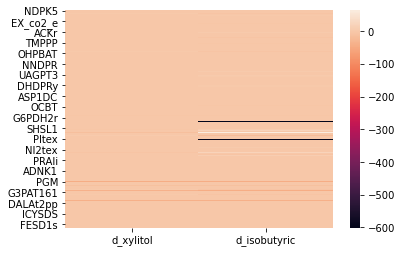

In [28]:
sns.heatmap(delta_flux)